# BIBTEX CITATION AIF-360
@misc{aif360-oct-2018,
    title = "{AI Fairness} 360:  An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted Algorithmic Bias",
    author = {Rachel K. E. Bellamy and Kuntal Dey and Michael Hind and
	Samuel C. Hoffman and Stephanie Houde and Kalapriya Kannan and
	Pranay Lohia and Jacquelyn Martino and Sameep Mehta and
	Aleksandra Mojsilovic and Seema Nagar and Karthikeyan Natesan Ramamurthy and
	John Richards and Diptikalyan Saha and Prasanna Sattigeri and
	Moninder Singh and Kush R. Varshney and Yunfeng Zhang},
    month = oct,
    year = {2018},
    url = {https://arxiv.org/abs/1810.01943}
}

## Adult Dataset arguments

class aif360.datasets.AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], protected_attribute_names=['race', 'sex'], privileged_classes=[['White'], ['Male']], instance_weights_name=None, categorical_features=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'], custom_preprocessing=None, metadata={'label_maps': [{1.0: '>50K', 0.0: '<=50K'}], 'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-white'}, {1.0: 'Male', 0.0: 'Female'}]})


__init__(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], protected_attribute_names=['race', 'sex'], privileged_classes=[['White'], ['Male']], instance_weights_name=None, categorical_features=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'], custom_preprocessing=None, metadata={'label_maps': [{1.0: '>50K', 0.0: '<=50K'}], 'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-white'}, {1.0: 'Male', 0.0: 'Female'}]})

# READ RAW DATA 

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

In [2]:
# constraints = "equalized_odds"
constraints = "demographic_parity"

# sensitive_feature = "Sex"
sensitive_feature = "Race"

In [3]:
# Source: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"] 

# Change these to local file if available
train_data = 'adult.data'
test_data = 'adult.test'

# This will download 3.8M
original_train = pd.read_csv(train_data, names=features, sep=r'\s*,\s*', 
                             engine='python', na_values="?")
# This will download 1.9M
original_test = pd.read_csv(test_data, names=features, sep=r'\s*,\s*', 
                            engine='python', na_values="?", skiprows=1)

num_train = len(original_train)
original = pd.concat([original_train, original_test])
roc_original = original
labels = original['Target']
labels = labels.replace('<=50K', 0).replace('>50K', 1)
labels = labels.replace('<=50K.', 0).replace('>50K.', 1)

# peak into the original_train and original_test data
print(original_train.head())
print("**************************")
print(original_test.head())

   Age         Workclass  fnlwgt  Education  Education-Num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       Marital Status         Occupation   Relationship   Race     Sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   Capital Gain  Capital Loss  Hours per week        Country Target  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [4]:
## extract sensitive features
if sensitive_feature == "Sex":
    A = original_test["Sex"]
    # A_str_test = A.map({ 0:"Female", 1:"Male"})
    A_str_test = pd.get_dummies(A,drop_first=True)
    A_ = original_train["Sex"]
    A_str_train = pd.get_dummies(A_,drop_first=True)
if sensitive_feature == "Race":
    A = original_test["Race"]
    # A_str_test = A.map({ 0:"Female", 1:"Male"})
    A_str_test = A.apply(lambda row: 1 if row == 'White' else 0)
    A_ = original_train["Race"]
    A_str_train = A_.apply(lambda row: 1 if row == 'White' else 0)

In [5]:
import scipy.stats as ss
# Redundant column
del original["Education"]

# Remove target variable
del original["Target"]

def data_transform(df):
    """Normalize features."""
    binary_data = pd.get_dummies(df)
    feature_cols = binary_data[binary_data.columns[:-2]]
    scaler = preprocessing.StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(feature_cols), columns=feature_cols.columns)
    return data

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    ## Chi-Squared test with the null hypothesis of independence of the two variables.
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))





In [6]:
# cramer V test
import pprint as pp

### [Workclass", "Martial Status","Occupation", "Relationship", "Race", "Sex","Country"]

temp_train = original[:num_train]
cat_features = ["Workclass", "Marital Status","Occupation", "Relationship", "Race", "Sex","Country"]
dic = {}
vals = []

for i in cat_features:
    for j in cat_features:
        if i != j:
            cf_mtx = pd.crosstab(temp_train[i], temp_train[j])
            vals.append(cf_mtx.values)
            dic[round(cramers_v(cf_mtx.values),3)] = tuple((i,j))






In [7]:
pp.pprint(dic)


{0.03: ('Country', 'Workclass'),
 0.055: ('Race', 'Workclass'),
 0.056: ('Country', 'Sex'),
 0.064: ('Country', 'Marital Status'),
 0.068: ('Country', 'Occupation'),
 0.076: ('Marital Status', 'Workclass'),
 0.078: ('Country', 'Relationship'),
 0.08: ('Race', 'Occupation'),
 0.083: ('Race', 'Marital Status'),
 0.089: ('Relationship', 'Workclass'),
 0.097: ('Race', 'Relationship'),
 0.118: ('Sex', 'Race'),
 0.13: ('Occupation', 'Marital Status'),
 0.143: ('Sex', 'Workclass'),
 0.177: ('Relationship', 'Occupation'),
 0.215: ('Occupation', 'Workclass'),
 0.421: ('Country', 'Race'),
 0.434: ('Sex', 'Occupation'),
 0.462: ('Sex', 'Marital Status'),
 0.488: ('Relationship', 'Marital Status'),
 0.649: ('Sex', 'Relationship')}


In [8]:

## cleaning the total data which is original_train and original_test concatenated
data = data_transform(original)

## create separate train and test data w/ labels
train_data = data[:num_train]
train_labels = labels[:num_train]
test_data = data[num_train:]
test_labels = labels[num_train:]

In [9]:
## summary of train data
train_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,-0.004518,0.001082,0.001008,-0.000190,-0.000493,0.001216,0.000973,0.000295,0.000716,0.006148,...,0.000529,0.001457,-0.006361,-0.004344,-0.002963,0.002113,0.006459,-0.002479,0.001307,-0.005166
std,0.994899,0.999498,1.000690,0.991056,0.999900,0.996458,1.002725,1.000540,1.024711,0.997402,...,1.003384,1.017085,0.910268,0.964175,0.925867,1.021476,1.084755,0.948732,1.027408,1.006746
min,-1.578629,-1.679680,-3.531030,-0.144804,-0.217127,-3.181452,-0.173795,-0.261940,-0.014310,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,-2.957854
25%,-0.776316,-0.680257,-0.419335,-0.144804,-0.217127,-0.034087,-0.173795,-0.261940,-0.014310,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
50%,-0.119879,-0.107082,-0.030373,-0.144804,-0.217127,-0.034087,-0.173795,-0.261940,-0.014310,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
75%,0.682433,0.448727,0.747550,-0.144804,-0.217127,0.369421,-0.173795,-0.261940,-0.014310,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
max,3.745808,12.263303,2.303397,13.274382,10.591794,4.727312,5.753915,3.817672,69.879897,0.663711,...,12.828332,23.672818,26.981199,16.261785,48.216279,20.584291,27.393711,40.336914,42.520148,0.338083


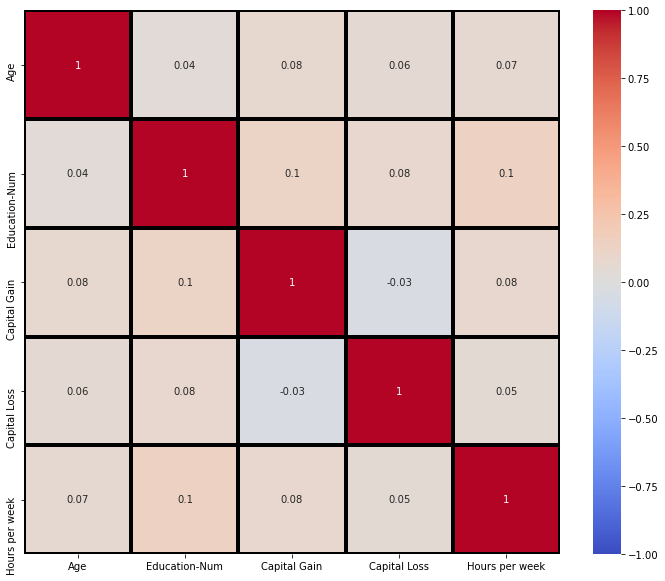

In [10]:
num_train_data = train_data[["Age","Education-Num","Capital Gain","Capital Loss","Hours per week"]]

plt.figure(figsize=(12,10))
cor = num_train_data.corr() # pearson correlation
sns.heatmap(cor,annot=True,cmap= 'coolwarm',fmt='.1g',vmin=-1, vmax=1, center= 0,linewidths=3, linecolor='black')
plt.show()

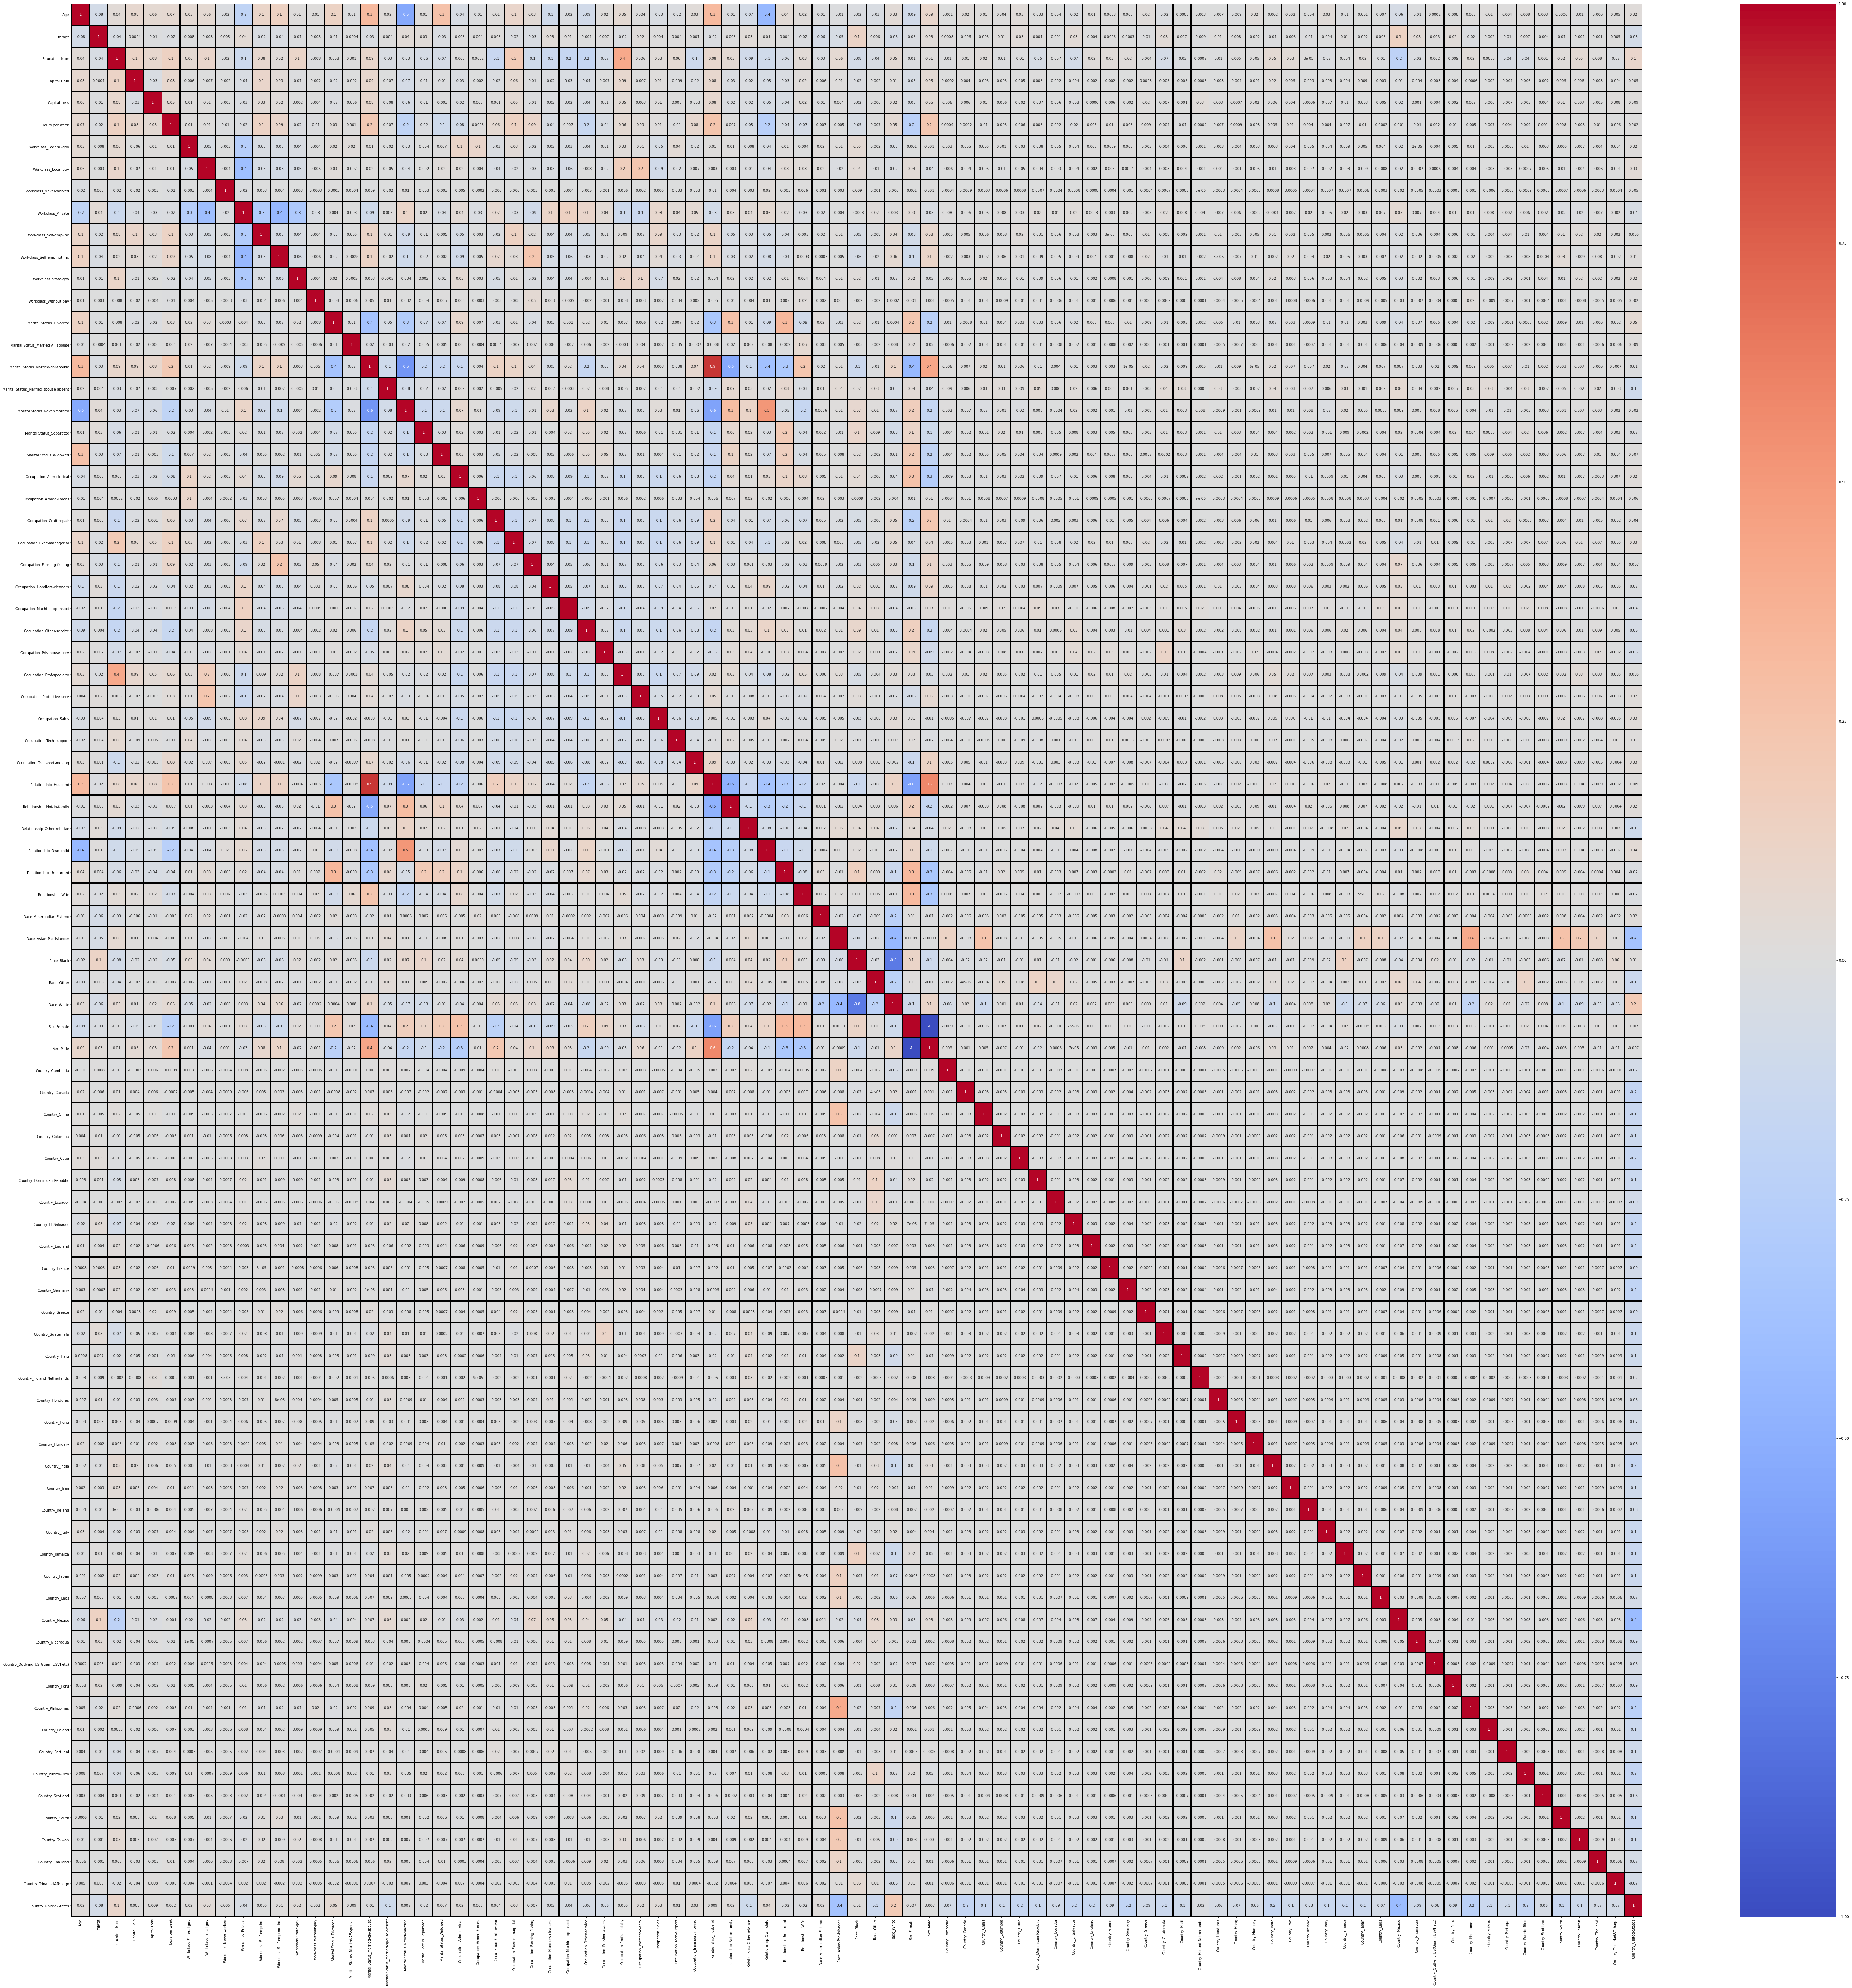

<Figure size 432x288 with 0 Axes>

In [11]:
# sns.heatmap(train_data)
# pearson correlation

# plt.figure(figsize=(100,100))
# cor = train_data.corr()
# sns.heatmap(cor,annot=True,cmap= 'coolwarm',fmt='.1g',vmin=-1, vmax=1, center= 0,linewidths=2, linecolor='black')
# plt.show()
# plt.savefig('corr_all_featues.pdf')

In [12]:
## summary of test data 
test_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,...,Country_Philippines,Country_Poland,Country_Portugal,Country_Puerto-Rico,Country_Scotland,Country_South,Country_Taiwan,Country_Thailand,Country_Trinadad&Tobago,Country_United-States
count,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,...,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,0.009035,-0.002163,-0.002015,0.000381,0.000985,-0.002433,-0.001945,-0.000590,-0.001431,-0.012295,...,-0.001059,-0.002914,0.012722,0.008688,0.005925,-0.004225,-0.012918,0.004958,-0.002614,0.010331
std,1.010125,1.001060,0.998677,1.017713,1.000260,1.007103,0.994586,0.998981,0.948712,1.005125,...,0.993259,0.964980,1.158752,1.068055,1.133847,0.955651,0.804043,1.095400,0.942857,0.986350
min,-1.578629,-1.668250,-3.531030,-0.144804,-0.217127,-3.181452,-0.173795,-0.261940,-0.014310,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,-2.957854
25%,-0.776316,-0.690588,-0.419335,-0.144804,-0.217127,-0.034087,-0.173795,-0.261940,-0.014310,-1.506680,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
50%,-0.119879,-0.112053,-0.030373,-0.144804,-0.217127,-0.034087,-0.173795,-0.261940,-0.014310,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
75%,0.682433,0.461349,0.747550,-0.144804,-0.217127,0.369421,-0.173795,-0.261940,-0.014310,0.663711,...,-0.077952,-0.042243,-0.037063,-0.061494,-0.020740,-0.048581,-0.036505,-0.024791,-0.023518,0.338083
max,3.745808,12.317231,2.303397,13.274382,9.137702,4.727312,5.753915,3.817672,69.879897,0.663711,...,12.828332,23.672818,26.981199,16.261785,48.216279,20.584291,27.393711,40.336914,42.520148,0.338083


In [13]:
## FAIRNESS

## use fair learn

#####################################################################
# DP: Demographic Parity
# EO: equalized odds --> Equal Opportunity is a relaxed version of it
# False Positive 
# True Positive 
# Error Rate Parity 
#####################################################################



# USING FAIRLEARN

In [14]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

## FIT LOG REG

In [15]:
from sklearn import linear_model
cls = linear_model.LogisticRegression()
cls.fit(train_data, train_labels)
predictions = cls.predict(test_data)

# accuracy of model
acc = len(test_labels[predictions==test_labels])/len(test_labels)*100.0

print("vanilla log regr accuracy = ", acc)

vanilla log regr accuracy =  85.27117498925128


# USE LIGHTGBM

### gradient boosting framework -- tree based learning 

"While other algorithms trees grow horizontally, LightGBM algorithm grows vertically meaning it grows leaf-wise and other algorithms grow level-wise. LightGBM chooses the leaf with large loss to grow. It can lower down more loss than a level wise algorithm when growing the same leaf.

LightGBM is called “Light” because of its computation power and giving results faster. It takes less memory to run and is able to deal with large amounts of data.
"
https://www.analyticssteps.com/blogs/what-light-gbm-algorithm-how-use-it



In [16]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'cross_entropy', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)

In [17]:
model.fit(train_data, train_labels)

LGBMClassifier(max_depth=3, metric='cross_entropy', num_leaves=10,
               objective='binary')

In [18]:
# Scores on test set
test_scores = model.predict_proba(test_data)[:, 1]
test_pred = model.predict(test_data)

In [19]:
model.predict_proba(test_data)[:,1]

array([0.00669496, 0.1916167 , 0.33279486, ..., 0.70404409, 0.2357183 ,
       0.75754238])

In [20]:
model.predict(test_data)

array([0, 0, 0, ..., 1, 0, 1])

In [21]:
# Train AUC
roc_auc_score(train_labels, model.predict_proba(train_data)[:, 1])

0.9254984147925456

In [22]:
# ACCURACY
accuracy_score(test_labels, test_pred)

0.8695411829740188

In [23]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(train_labels)) * 1


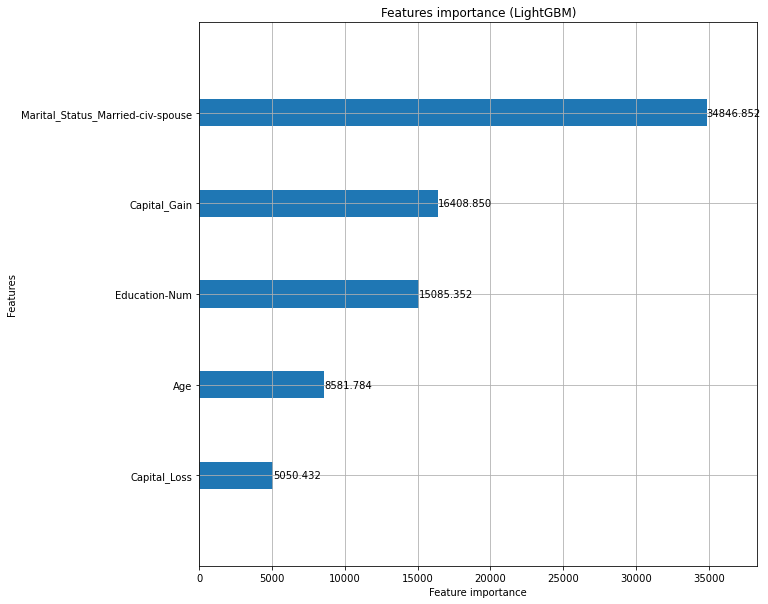

In [24]:
# LightGBM feature importance 
lgb.plot_importance(model, figsize = (10,10), height=0.3, title="Features importance (LightGBM)", importance_type="gain", max_num_features=5) 
plt.show()


In [25]:
# USE FAIRLEARN now
# use MetricFrame for analysis 
##     selection_rate, demographic_parity_difference, demographic_parity_ratio,
##    false_positive_rate, false_negative_rate,
##    false_positive_rate_difference, false_negative_rate_difference,
##    equalized_odds_difference, count



mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    test_labels, test_preds, sensitive_features=A_str_test)

mf.by_group

/Users/abhishek/anaconda3/lib/python3.8/site-packages/fairlearn/metrics/_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
Race,,
0,0.122284,0.154494
1,0.214614,0.124355


In [26]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
#         "Overall selection rate": (
#             lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
#         "Demographic parity ratio": (
#             lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
#         "------": (lambda x: "", True),
#         "Overall balanced error rate": (
#             lambda x: 1-balanced_accuracy_score(y_true, x), True),
#         "Balanced error rate difference": (
#             lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
#         " ------": (lambda x: "", True),
#         "False positive rate difference": (
#             lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
#         "False negative rate difference": (
#             lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
#         "  ------": (lambda x: "", True),
#         "Overall AUC": (
#             lambda x: roc_auc_score(y_true, x), False),
        "Accuracy": (
             lambda x: accuracy_score(y_true, x), True)
#         "AUC difference": (
#             lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [27]:
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, test_labels, A_str_test)

,Unmitigated
Demographic parity difference,0.147489
Equalized odds difference,0.092330
Accuracy,0.817272


## MITIGATION

In [28]:
from fairlearn.reductions import EqualizedOdds, TruePositiveRateParity,ErrorRateParity,DemographicParity
dp = DemographicParity(difference_bound=0.01)
tprp = TruePositiveRateParity(difference_bound=0.01)
eo = EqualizedOdds(difference_bound=0.01)
erp = ErrorRateParity(difference_bound=0.01)
# demographic parity
dp.load_data(test_data, test_labels, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Demographic Parity")
print(dp.gamma(lambda X: test_preds))

# Equalized Odds
eo.load_data(test_data, test_labels, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Equalized Odds")
print(eo.gamma(lambda X: test_preds))

# ErrorRateParity
erp.load_data(test_data, test_labels, sensitive_features=A_str_test)
print("------------------------------------------")
print("           Error Rate Parity")
print(erp.gamma(lambda X: test_preds))



------------------------------------------
           Demographic Parity
sign  event  group_id
+     all    0          -0.126336
             1           0.021153
-     all    0           0.126336
             1          -0.021153
dtype: float64
------------------------------------------
           Equalized Odds
sign  event    group_id
+     label=0  0          -0.077636
               1           0.014694
      label=1  0          -0.027349
               1           0.002790
-     label=0  0           0.077636
               1          -0.014694
      label=1  0           0.027349
               1          -0.002790
dtype: float64
------------------------------------------
           Error Rate Parity
sign  event  group_id
+     all    0          -0.055533
             1           0.009298
-     all    0           0.055533
             1          -0.009298
dtype: float64


## Threshold Optimizer w Demographic Parity 

In [29]:
import pprint

postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints="demographic_parity",
    prefit=True)

balanced_idx1 = train_data[train_labels==1].index
pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = train_data.loc[pp_train_idx, :]
Y_train_balanced = train_labels.loc[pp_train_idx]
A_train_balanced = A_.loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)
postprocess_scores = model.predict_proba(test_data)[:, 1]

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

/Users/abhishek/anaconda3/lib/python3.8/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.147489,0.074651
Equalized odds difference,0.092330,0.150327
Accuracy,0.817272,0.849948


In [30]:
# blah = (get_metrics_df(models_dict, test_labels, A_str_test))
# blah.to_csv('/Users/abhishek/Desktop/ADULT_CSV/DP/all_feat.csv', 
#             index=True,
#             header = ['Unmit:all feat(DP)','ThrOpt:all feat(DP)'])

## Threshold Optimizer w Equalized Odds

In [31]:
import pprint

postprocess_est = ThresholdOptimizer(
    estimator = model,
    constraints= "equalized_odds",
    prefit=True)

balanced_idx1 = train_data[train_labels==1].index
pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = train_data.loc[pp_train_idx, :]
Y_train_balanced = train_labels.loc[pp_train_idx]
A_train_balanced = A_.loc[pp_train_idx]


postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

/Users/abhishek/anaconda3/lib/python3.8/site-packages/fairlearn/postprocessing/_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.147489,0.036913
Equalized odds difference,0.092330,0.028330
Accuracy,0.817272,0.831214


## Exponentiated Gradient w Demographic Parity

In [32]:
from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
xgc = XGBClassifier(verbosity=0)

eg = ExponentiatedGradient(estimator= clf, constraints= DemographicParity())
eg.fit(train_data,train_labels, sensitive_features=A_)
eg_test_preds = eg.predict(test_data)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ExponentiatedGrad": (eg_test_preds,eg_test_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ExponentiatedGrad
Demographic parity difference,0.147489,0.010241
Equalized odds difference,0.092330,0.079904
Accuracy,0.817272,0.833610


## Exponentiated Gradient w Equalized odds

In [33]:
from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
xgc = XGBClassifier(verbosity=0)

eg = ExponentiatedGradient(estimator= clf, constraints= EqualizedOdds())
eg.fit(train_data,train_labels, sensitive_features=A_)
eg_test_preds = eg.predict(test_data)

models_dict = {"Unmitigated": (test_preds, test_scores),
              "ExponentiatedGrad": (eg_test_preds,eg_test_preds)}
(get_metrics_df(models_dict, test_labels, A_str_test))

,Unmitigated,ExponentiatedGrad
Demographic parity difference,0.147489,0.103401
Equalized odds difference,0.092330,0.126037
Accuracy,0.817272,0.843376
